# Chnages in code
-------------------------------------------------

## Defining the Likelihood Matrix A

In [ ]:
A = np.array([[1.0, 0.0, 0.0],
              [0.0, 0.5, 0.0],
              [0.0, 0.5, 0.0],
              [0.0, 0.0, 0.5],
              [0.0, 0.0, 0.5]])

A is a normal NumPy array. pymdp expects an object array for multiple modalities. This setup can break.

In [ ]:
A_matrix = np.array([...])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)
A = np.empty((1,), dtype=object)
A[0] = A_matrix

Normalizes columns + wraps in object array. Fully compatible with pymdp.

## Setting the Prior over A -> pA

In [ ]:
pA = utils.dirichlet_like(A, scale=1.1)

Avoids warnings because A is now correctly formatted.

## Instantiating the Agent

In [ ]:
agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
agent.policies = construct_policies([2])

Explicit policy construction added for 2-action case.

## Environment _build()

In [ ]:
next_play = s if x == (self.shape[1] - 1) else s + 1
next_notplay = s if x == 0 else s - 1

Prevents invalid state transitions like KeyError: -1.

## Simulation Loop

In [ ]:
qx = agent.infer_states([obs])
q_pi, efe = agent.infer_policies()
action = agent.sample_action()
pA_t = agent.update_A([obs])
obs = env.step(action)

Full loop with state/policy inference, learning, logging, and action matrix tracking.

## Visualization

In [ ]:
df = pd.DataFrame({...})
plt.plot(...)
display(df)

Shows trends in action choices across time. Adds readability and analysis value.

# Updated code
----------------------------------------------------------------

In [ ]:
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# Generative model setup (A, B, C, D)
# -----------------------------
# Likelihood matrix A
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True) # normalisation to 1
A = np.empty((1,), dtype=object) # Creates an object array with 1 slot
A[0] = A_matrix # returns the likelihood matrix for modality 0

# Dirichlet prior over A
pA = utils.dirichlet_like(A, scale=1.1)

# Transition matrix B (3 hidden states, 2 actions)
B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])

# Preference vector C and prior over initial states D
C = np.array([0, -1, 1, -1, 1]).reshape(-1, 1) # winning if he plays, loosing if he plays, winning if he doesn't play, loosing if he doesn't play
D = np.array([1, 0, 0])

# -----------------------------
# Instantiate agent
# -----------------------------
agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
agent.policies = construct_policies([2])

# -----------------------------
# Defining the volleyball environment
# -----------------------------
class CausalEnv:
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)
        state = self.P[self.state][action]
        self.state = state
        self.last_action = action
        return state

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("init_state is out of bounds")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state

    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}
            next_play = s if x == (self.shape[1] - 1) else s + 1
            next_notplay = s if x == 0 else s - 1
            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    @property
    def position(self):
        return self.state

# -----------------------------
# Simulation
# -----------------------------

env = CausalEnv()
obs = [1]
T = 40
pA_history = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))
log = []

for t in range(T):
    qx = agent.infer_states([obs])
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    pA_t = agent.update_A([obs])
    pA_history.append(pA_t)
    obs = env.step(action)
    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")
    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]

# -----------------------------
# Display action log
# -----------------------------
df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
print(df)

# -----------------------------
# Plot action history
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Play"], label="Play", marker='o')
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x')
plt.title("Agent Actions Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action Taken")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

    Step  Play  Not_Play
0      0   1.0       0.0
1      1   1.0       0.0
2      2   0.0       1.0
3      3   0.0       1.0
4      4   0.0       1.0
5      5   0.0       1.0
6      6   0.0       1.0
7      7   0.0       1.0
8      8   0.0       1.0
9      9   0.0       1.0
10    10   0.0       1.0
11    11   0.0       1.0
12    12   0.0       1.0
13    13   0.0       1.0
14    14   0.0       1.0
15    15   0.0       1.0
16    16   0.0       1.0
17    17   0.0       1.0
18    18   0.0       1.0
19    19   0.0       1.0
20    20   0.0       1.0
21    21   0.0       1.0
22    22   0.0       1.0
23    23   0.0       1.0
24    24   0.0       1.0
25    25   0.0       1.0
26    26   0.0       1.0
27    27   0.0       1.0
28    28   0.0       1.0
29    29   0.0       1.0
30    30   0.0       1.0
31    31   0.0       1.0
32    32   0.0       1.0
33    33   0.0       1.0
34    34   0.0       1.0
35    35   0.0       1.0
36    36   0.0       1.0
37    37   0.0       1.0
38    38   0.0       1.0


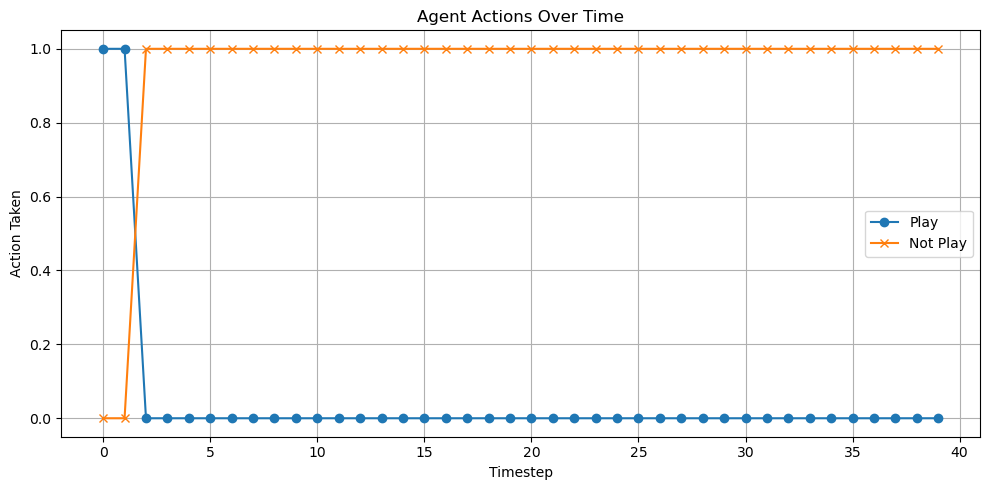

In [11]:
# Final Combined Active Inference Volleyball Agent
# - Based on Version 2 (functional)
# - Includes select features from Version 1 (e.g., additional methods)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# -----------------------------
# Generative model setup (A, B, C, D)
# -----------------------------
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)
A = np.empty((1,), dtype=object)
A[0] = A_matrix
pA = utils.dirichlet_like(A, scale=1.1)

B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])

C = np.array([0, -1, 1, -1, 1]).reshape(-1, 1)
D = np.array([1, 0, 0])

agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
agent.policies = construct_policies([2])

# -----------------------------
# Environment class
# -----------------------------
class CausalEnv:
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)
        next_state = self.P[self.state][action]
        self.state = next_state
        self.last_action = action
        return next_state

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("init_state is out of bounds")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state

    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}
            next_play = s if x == (self.shape[1] - 1) else s + 1
            next_notplay = s if x == 0 else s - 1
            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def sample_action(self):
        return np.random.randint(self.n_control)

    def get_transition_dist(self):
        B = np.zeros([self.n_states, self.n_states, self.n_control])
        for s in range(self.n_states):
            for a in range(self.n_control):
                ns = int(self.P[s][a])
                B[ns, s, a] = 1
        return B

    def get_likelihood_dist(self):
        return np.eye(self.n_observations, self.n_states)

    @property
    def position(self):
        return self.state

# -----------------------------
# Run simulation
# -----------------------------
env = CausalEnv()
obs = [1]
T = 40
pA_history = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))
log = []

for t in range(T):
    qx = agent.infer_states([obs])
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    pA_t = agent.update_A([obs])
    pA_history.append(pA_t)
    obs = env.step(action)
    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")
    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]

# -----------------------------
# Display and plot actions
# -----------------------------
df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
print(df)

plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Play"], label="Play", marker='o')
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x')
plt.title("Agent Actions Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action Taken")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


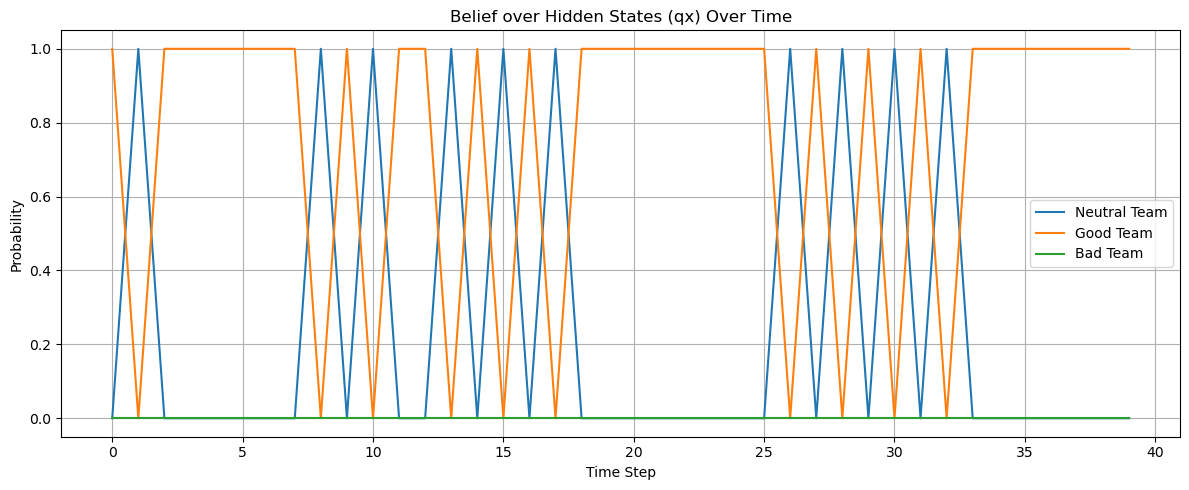

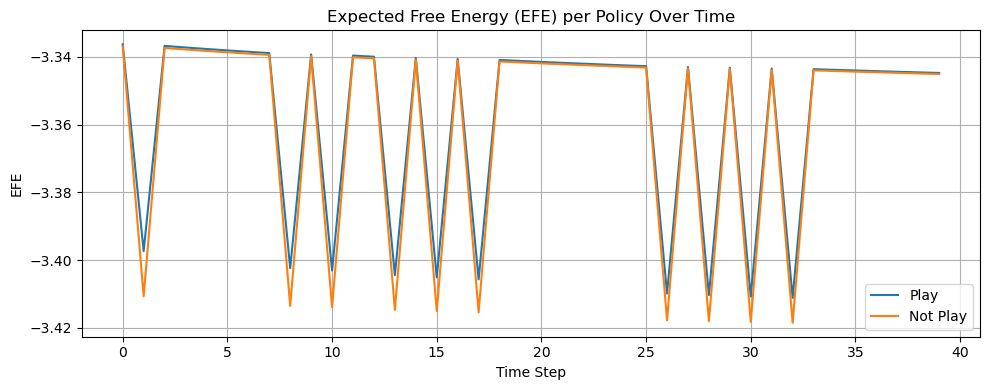

In [17]:
# Initialize environment and observation
env = CausalEnv()
obs = [1]
T = 40

qx_history = []
efe_history = []

# Rerun simulation and store beliefs and EFEs
for t in range(T):
    qx = agent.infer_states([obs])
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    agent.update_A([obs])
    obs = env.step(action)

    qx_history.append(qx[0])  # belief over hidden states
    efe_history.append(efe.squeeze())  # expected free energy per policy

# Convert to arrays
qx_array = np.array(qx_history)
efe_array = np.array(efe_history)

# Plot beliefs (qx)
plt.figure(figsize=(12, 5))
plt.plot(qx_array[:, 0], label="Neutral Team")
plt.plot(qx_array[:, 1], label="Good Team")
plt.plot(qx_array[:, 2], label="Bad Team")


plt.title("Belief over Hidden States (qx) Over Time")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot expected free energy (EFE)
plt.figure(figsize=(10, 4))
plt.plot(efe_array[:, 0], label="Play")
plt.plot(efe_array[:, 1], label="Not Play")
plt.title("Expected Free Energy (EFE) per Policy Over Time")
plt.xlabel("Time Step")
plt.ylabel("EFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


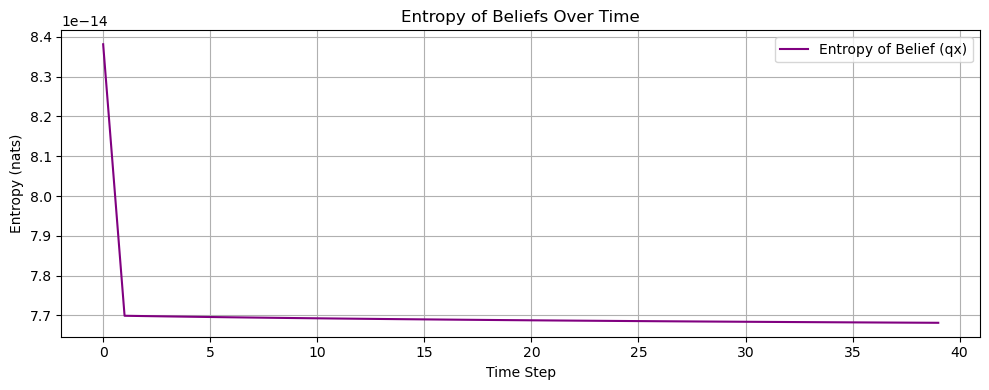

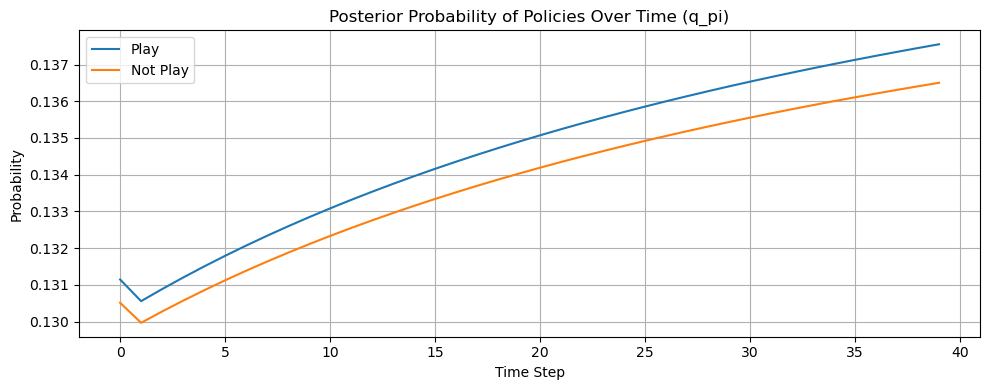

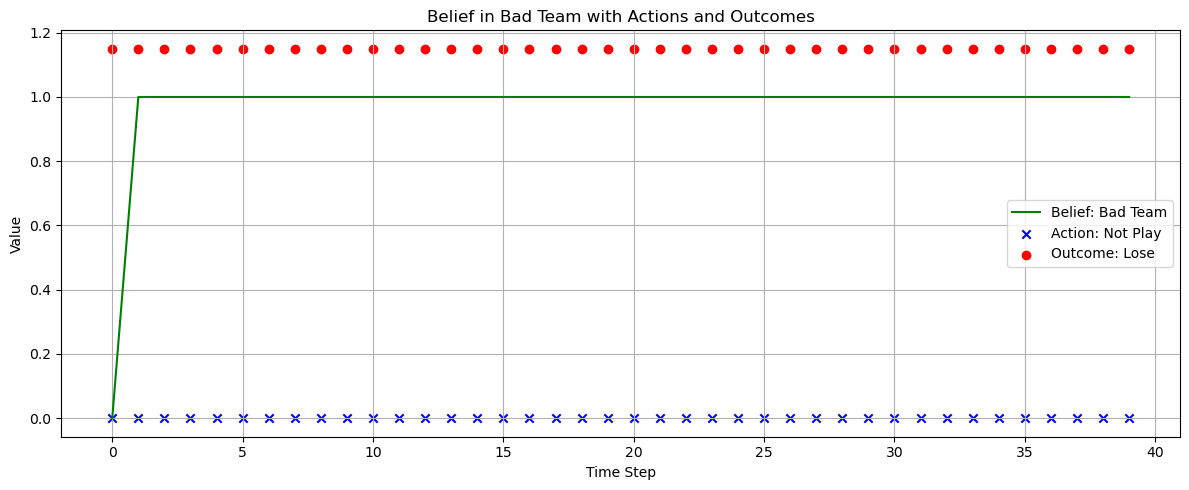

In [14]:
# Prepare storage for variables
qx_history = []
efe_history = []
qpi_history = []
action_history = []
outcome_history = []
entropy_history = []

env = CausalEnv()
obs = [1]
T = 40

for t in range(T):
    qx = agent.infer_states([obs])
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    agent.update_A([obs])
    obs = env.step(action)

    qx_array = qx[0]
    qx_history.append(qx_array)
    qpi_history.append(q_pi.squeeze())
    efe_history.append(efe.squeeze())
    action_history.append(action)
    outcome_history.append(0 if obs % 2 == 0 else 1)
    entropy = -np.sum(qx_array * np.log(qx_array + 1e-16))
    entropy_history.append(entropy)

# Convert everything to arrays
qx_array = np.array(qx_history)
efe_array = np.array(efe_history)
qpi_array = np.array(qpi_history)
entropy_array = np.array(entropy_history)
actions_np = np.array(action_history)
outcomes_np = np.array(outcome_history)

# ------------------------
# Belief entropy over time
# ------------------------
plt.figure(figsize=(10, 4))
plt.plot(range(T), entropy_array, color='purple', label="Entropy of Belief (qx)")
plt.title("Entropy of Beliefs Over Time")
plt.xlabel("Time Step")
plt.ylabel("Entropy (nats)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------
# Policy posteriors over time
# ------------------------
# Plot policy posteriors over time
plt.figure(figsize=(10, 4))
plt.plot(range(T), qpi_array[:, 0], label="Play")
plt.plot(range(T), qpi_array[:, 1], label="Not Play")
plt.title("Posterior Probability of Policies Over Time (q_pi)")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot belief in 'Bad Team' with actions and outcomes
plt.figure(figsize=(12, 5))
plt.plot(range(T), qx_array[:, 2], label="Belief: Bad Team", color='green')
plt.scatter(range(T), actions_np * 1.05, color='blue', label="Action: Not Play", marker='x')
plt.scatter(range(T), outcomes_np * 1.15, color='red', label="Outcome: Lose", marker='o')
plt.title("Belief in Bad Team with Actions and Outcomes")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



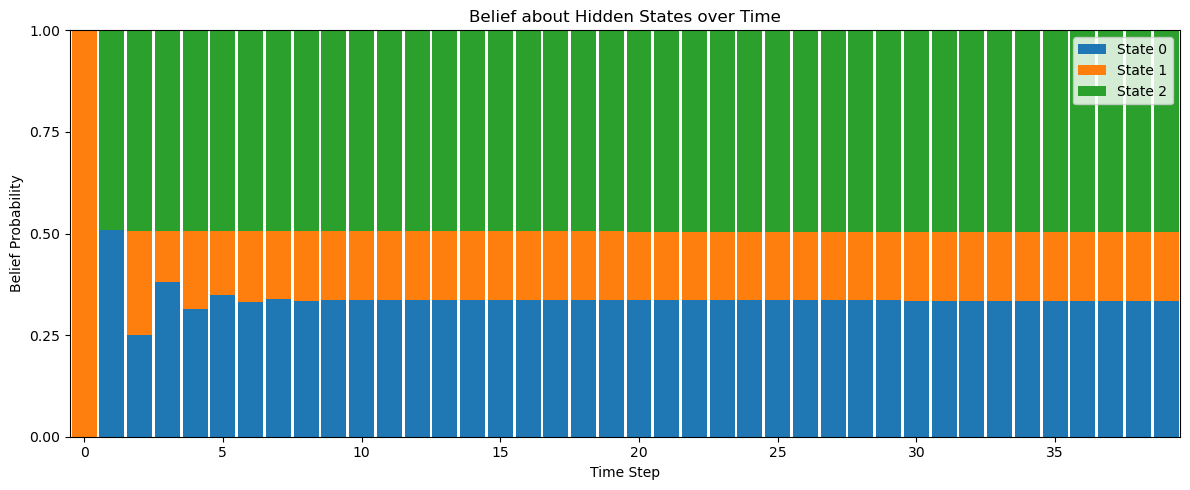

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Choose pretty paper-style colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

# Set up figure
plt.figure(figsize=(12, 5))
bottom = np.zeros(len(qx_array))  # start from bottom = 0

# Plot stacked bars, one state at a time
for i in range(qx_array.shape[1]):
    plt.bar(range(len(qx_array)),
            qx_array[:, i],
            bottom=bottom,
            color=colors[i],
            width=0.9,
            label=f"State {i}")
    bottom += qx_array[:, i]  # stack next bar segment on top

# Styling to match your image
plt.title("Belief about Hidden States over Time")
plt.xlabel("Time Step")
plt.ylabel("Belief Probability")
plt.ylim(0, 1.0)
plt.xlim(-0.5, len(qx_array) - 0.5)
plt.xticks(np.arange(0, len(qx_array), 5))
plt.yticks(np.linspace(0, 1.0, 5))
plt.grid(False)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


    Step  Play  Not_Play
0      0   1.0       0.0
1      1   0.0       1.0
2      2   0.0       1.0
3      3   1.0       0.0
4      4   1.0       0.0
5      5   1.0       0.0
6      6   1.0       0.0
7      7   1.0       0.0
8      8   1.0       0.0
9      9   1.0       0.0
10    10   1.0       0.0
11    11   1.0       0.0
12    12   1.0       0.0
13    13   1.0       0.0
14    14   1.0       0.0
15    15   1.0       0.0
16    16   1.0       0.0
17    17   1.0       0.0
18    18   1.0       0.0
19    19   1.0       0.0
20    20   1.0       0.0
21    21   1.0       0.0
22    22   1.0       0.0
23    23   1.0       0.0
24    24   1.0       0.0
25    25   1.0       0.0
26    26   1.0       0.0
27    27   1.0       0.0
28    28   1.0       0.0
29    29   1.0       0.0
30    30   1.0       0.0
31    31   1.0       0.0
32    32   1.0       0.0
33    33   1.0       0.0
34    34   1.0       0.0
35    35   1.0       0.0
36    36   1.0       0.0
37    37   1.0       0.0
38    38   1.0       0.0


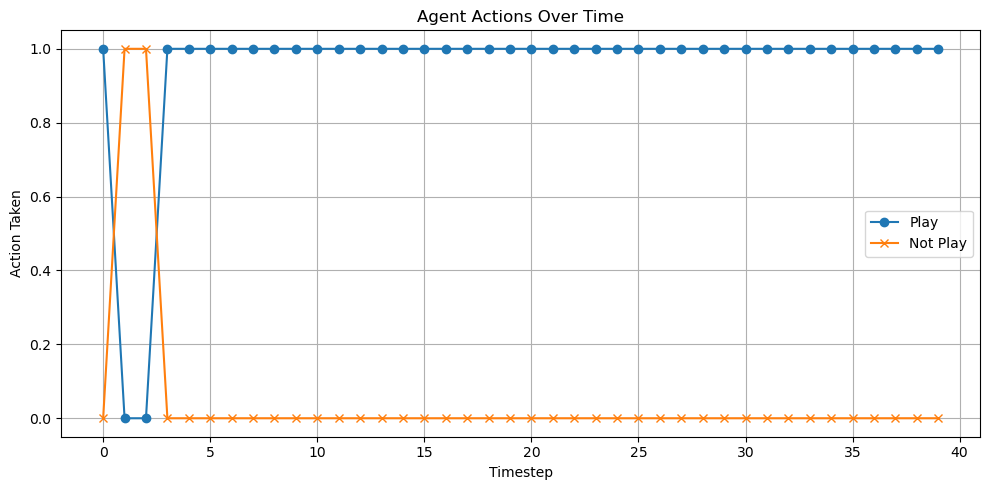

In [4]:
# Annotated Shell for Active Inference Agent in a Volleyball Task

# ===============================
# 1. Import necessary libraries
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# ===============================
# 2. Define the generative model
# ===============================
# A: Observation likelihood matrix (object array format)
# B: Transition matrix over hidden states (action-dependent)
# C: Preference over observations (utility)
# D: Prior over hidden states

# Placeholder setup for matrices A, B, C, D
A = ...  # Expected shape: object array [n_modalities] of (n_obs, n_states)
pA = utils.dirichlet_like(A)  # Prior over A (Dirichlet)
B = ...  # Shape: (n_states, n_states, n_actions)
C = ...  # Shape: (n_obs, 1)
D = ...  # Shape: (n_states,)

# ===============================
# 3. Instantiate the agent
# ===============================
agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
agent.policies = construct_policies([n_actions])

# ===============================
# 4. Define the Environment Class
# ===============================
class CausalEnv:
    def __init__(self, shape=[2, 2]):
        self.shape = shape
        self._build()
        self.set_init_state()

    def _build(self):
        # Transition logic from one grid cell to another
        self.P = ...

    def step(self, action):
        # Move to next state based on action
        return self.P[self.state][action]

    def set_init_state(self, init_state=None):
        # Set or randomly initialize state
        ...

# ===============================
# 5. Run Simulation
# ===============================
T = 40  # number of time steps
env = CausalEnv()
obs = [initial_observation]

for t in range(T):
    qx = agent.infer_states([obs])
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    agent.update_A([obs])
    obs = env.step(action)
    # Store qx, q_pi, actions, outcomes, etc.

# ===============================
# 6. Visualize Results
# ===============================
# Create plots for beliefs (qx), EFE, entropy, etc.
plt.plot(...)  # Example: belief over time
plt.show()

    Step  Play  Not_Play
0      0   0.0       1.0
1      1   0.0       1.0
2      2   0.0       1.0
3      3   0.0       1.0
4      4   0.0       1.0
5      5   0.0       1.0
6      6   0.0       1.0
7      7   0.0       1.0
8      8   0.0       1.0
9      9   0.0       1.0
10    10   0.0       1.0
11    11   0.0       1.0
12    12   0.0       1.0
13    13   0.0       1.0
14    14   0.0       1.0
15    15   0.0       1.0
16    16   0.0       1.0
17    17   0.0       1.0
18    18   0.0       1.0
19    19   0.0       1.0
20    20   0.0       1.0
21    21   0.0       1.0
22    22   0.0       1.0
23    23   0.0       1.0
24    24   0.0       1.0
25    25   0.0       1.0
26    26   0.0       1.0
27    27   0.0       1.0
28    28   0.0       1.0
29    29   0.0       1.0
30    30   0.0       1.0
31    31   0.0       1.0
32    32   0.0       1.0
33    33   0.0       1.0
34    34   0.0       1.0
35    35   0.0       1.0
36    36   0.0       1.0
37    37   0.0       1.0
38    38   0.0       1.0


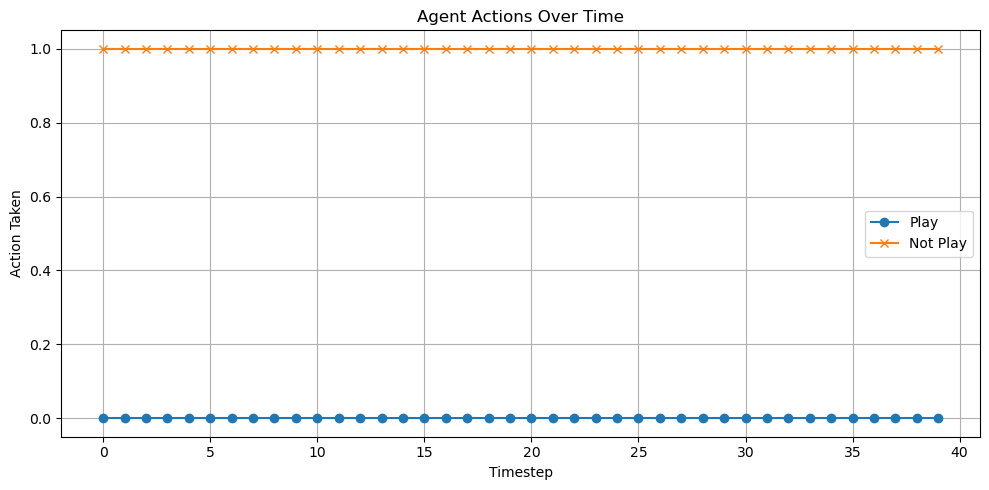

In [9]:
# Final Combined Active Inference Volleyball Agent (Exploratory Version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# -----------------------------
# Generative model setup (A, B, C, D)
# -----------------------------
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)
A = np.empty((1,), dtype=object)
A[0] = A_matrix

# ADD MORE UNCERTAINTY
pA = utils.dirichlet_like(A, scale=0.5)

# ADD NOISE TO TRANSITIONS
B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])
B += 0.05  # Add uniform noise
B = B / B.sum(axis=0, keepdims=True)  # Normalize

C = np.array([0, -1, 1, -1, 1]).reshape(-1, 1)
D = np.array([1, 0, 0])

agent = Agent(A=A, pA=pA, B=B, C=C, D=D)

# CORRECTLY CONSTRUCT POLICIES FOR 1 CONTROL FACTOR

agent.policies = construct_policies([2], policy_len=2)
agent.E = np.ones(len(agent.policies)) / len(agent.policies)  # ✅ fix shape mismatch

# LOWER POLICY PRECISION (exploration control)
agent.alpha = 1.0

# -----------------------------
# Environment class
# -----------------------------
class CausalEnv:
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)
        next_state = self.P[self.state][action]
        self.state = next_state
        self.last_action = action
        return next_state

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("init_state is out of bounds")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state

    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}
            next_play = s if x == (self.shape[1] - 1) else s + 1
            next_notplay = s if x == 0 else s - 1
            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def sample_action(self):
        return np.random.randint(self.n_control)

    def get_transition_dist(self):
        B = np.zeros([self.n_states, self.n_states, self.n_control])
        for s in range(self.n_states):
            for a in range(self.n_control):
                ns = int(self.P[s][a])
                B[ns, s, a] = 1
        return B

    def get_likelihood_dist(self):
        return np.eye(self.n_observations, self.n_states)

    @property
    def position(self):
        return self.state

# -----------------------------
# Run simulation
# -----------------------------
env = CausalEnv()
obs = [1]
T = 40
pA_history = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))
log = []

for t in range(T):
    qx = agent.infer_states([obs])
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    pA_t = agent.update_A([obs])
    pA_history.append(pA_t)
    obs = env.step(action)
    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")
    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]

# -----------------------------
# Display and plot actions
# -----------------------------
df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
print(df)

plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Play"], label="Play", marker='o')
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x')
plt.title("Agent Actions Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action Taken")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


    Step  Play  Not_Play
0      0   1.0       0.0
1      1   1.0       0.0
2      2   0.0       1.0
3      3   0.0       1.0
4      4   0.0       1.0
5      5   0.0       1.0
6      6   0.0       1.0
7      7   0.0       1.0
8      8   0.0       1.0
9      9   0.0       1.0
10    10   0.0       1.0
11    11   0.0       1.0
12    12   0.0       1.0
13    13   0.0       1.0
14    14   0.0       1.0
15    15   0.0       1.0
16    16   0.0       1.0
17    17   0.0       1.0
18    18   0.0       1.0
19    19   0.0       1.0
20    20   0.0       1.0
21    21   0.0       1.0
22    22   0.0       1.0
23    23   0.0       1.0
24    24   0.0       1.0
25    25   0.0       1.0
26    26   0.0       1.0
27    27   0.0       1.0
28    28   0.0       1.0
29    29   0.0       1.0
30    30   0.0       1.0
31    31   0.0       1.0
32    32   0.0       1.0
33    33   0.0       1.0
34    34   0.0       1.0
35    35   0.0       1.0
36    36   0.0       1.0
37    37   0.0       1.0
38    38   0.0       1.0


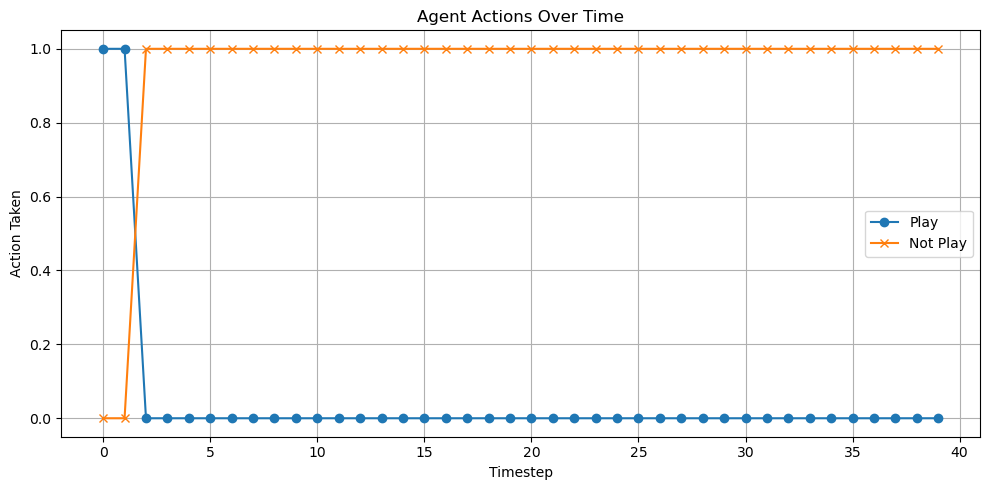

In [1]:
# Final Combined Active Inference Volleyball Agent (Exploratory Version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# -----------------------------
# Generative model setup (A, B, C, D)
# -----------------------------
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)
A = np.empty((1,), dtype=object)
A[0] = A_matrix

# ADD MORE UNCERTAINTY
pA = utils.dirichlet_like(A, scale=0.5)

# ADD NOISE TO TRANSITIONS
B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])
B += 0.05  # Add uniform noise
B = B / B.sum(axis=0, keepdims=True)  # Normalize

C = np.array([0.0, -0.1, 0.1, -0.1, 0.1]).reshape(-1, 1)

D = np.array([1, 0, 0])

agent = Agent(A=A, pA=pA, B=B, C=C, D=D)

# CORRECTLY CONSTRUCT POLICIES FOR 1 CONTROL FACTOR

agent.policies = construct_policies([2], policy_len=2)
agent.use_states_info_gain = True  # Important!
agent.E = np.ones(len(agent.policies)) / len(agent.policies)  # ✅ fix shape mismatch

# LOWER POLICY PRECISION (exploration control)
agent.alpha = 1.0

# -----------------------------
# Environment class
# -----------------------------
class CausalEnv:
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)
        next_state = self.P[self.state][action]
        self.state = next_state
        self.last_action = action
        return next_state

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("init_state is out of bounds")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state

    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}
            next_play = s if x == (self.shape[1] - 1) else s + 1
            next_notplay = s if x == 0 else s - 1
            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def sample_action(self):
        return np.random.randint(self.n_control)

    def get_transition_dist(self):
        B = np.zeros([self.n_states, self.n_states, self.n_control])
        for s in range(self.n_states):
            for a in range(self.n_control):
                ns = int(self.P[s][a])
                B[ns, s, a] = 1
        return B

    def get_likelihood_dist(self):
        return np.eye(self.n_observations, self.n_states)

    @property
    def position(self):
        return self.state

# -----------------------------
# Run simulation
# -----------------------------
env = CausalEnv()
obs = [1]
T = 40
pA_history = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))
log = []
entropy_list = []

for t in range(T):
    qx = agent.infer_states([obs])
    qx_single = qx[0]  # assuming only 1 hidden state factor
    entropy = -np.sum(qx_single * np.log(qx_single + 1e-16))
    entropy_list.append(entropy)
    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    pA_t = agent.update_A([obs])
    pA_history.append(pA_t)
    obs = env.step(action)
    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")
    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]

# -----------------------------
# Display and plot actions
# -----------------------------
df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
print(df)

plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Play"], label="Play", marker='o')
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x')
plt.title("Agent Actions Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action Taken")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


    Step  Play  Not_Play
0      0   1.0       0.0
1      1   0.0       1.0
2      2   1.0       0.0
3      3   0.0       1.0
4      4   1.0       0.0
5      5   1.0       0.0
6      6   1.0       0.0
7      7   1.0       0.0
8      8   1.0       0.0
9      9   1.0       0.0
10    10   1.0       0.0
11    11   1.0       0.0
12    12   1.0       0.0
13    13   1.0       0.0
14    14   1.0       0.0
15    15   1.0       0.0
16    16   1.0       0.0
17    17   1.0       0.0
18    18   1.0       0.0
19    19   1.0       0.0
20    20   1.0       0.0
21    21   1.0       0.0
22    22   1.0       0.0
23    23   1.0       0.0
24    24   1.0       0.0
25    25   1.0       0.0
26    26   1.0       0.0
27    27   1.0       0.0
28    28   1.0       0.0
29    29   1.0       0.0
30    30   1.0       0.0
31    31   0.0       1.0
32    32   1.0       0.0
33    33   1.0       0.0
34    34   1.0       0.0
35    35   1.0       0.0
36    36   1.0       0.0
37    37   1.0       0.0
38    38   1.0       0.0


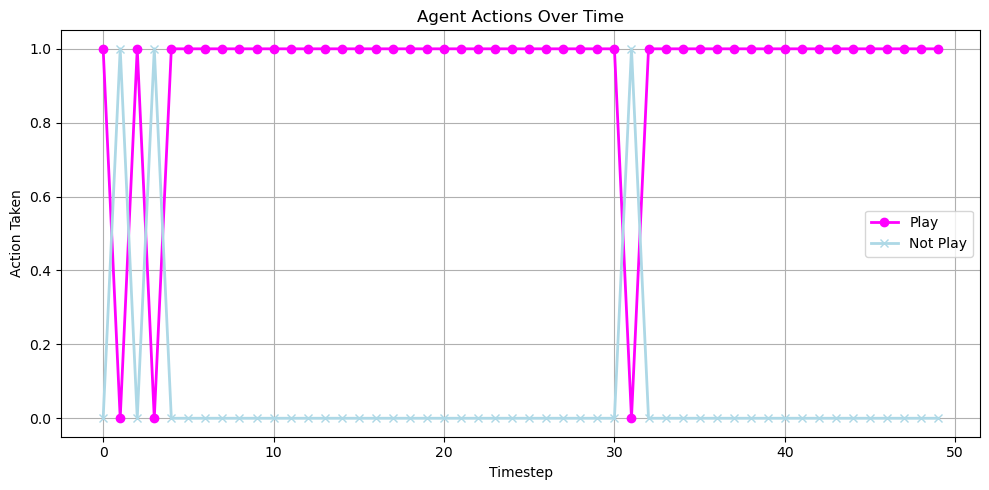

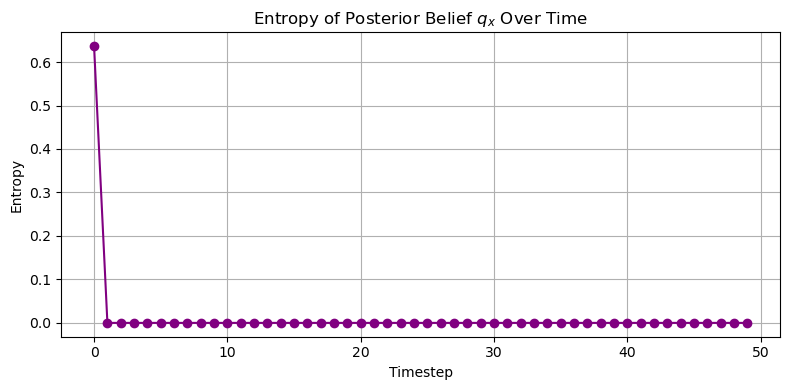

In [12]:
# Final Combined Active Inference Volleyball Agent (Exploratory Version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# -----------------------------
# Generative model setup (A, B, C, D)
# -----------------------------
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)
A = np.empty((1,), dtype=object)
A[0] = A_matrix

pA = utils.dirichlet_like(A, scale=0.5)  # More uncertainty in likelihood

B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])
B += 0.05  # Add noise
B = B / B.sum(axis=0, keepdims=True)

C = np.array([0.0, -0.01, 0.01, -0.01, 0.01]).reshape(-1, 1)  # Flattened preferences
D = np.array([1, 0, 0])

agent = Agent(A=A, pA=pA, B=B, C=C, D=D)

# Multi-step policies with proper shape
agent.policies = construct_policies([2], policy_len=3)
agent.E = np.ones(len(agent.policies)) / len(agent.policies)

# Exploration settings
agent.alpha = 0.1  # Low precision = more randomness
agent.use_states_info_gain = True
agent.use_param_info_gain = True

# -----------------------------
# Environment class
# -----------------------------
class CausalEnv:
    PLAY = 0
    NOTPLAY = 1
    CONTROL_NAMES = ["PLAY", "NOTPLAY"]

    def __init__(self, shape=[2, 2], init_state=None):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_observations = self.n_states
        self.n_control = 2
        self._build()
        self.set_init_state(init_state)
        self.last_action = None

    def reset(self, init_state=None):
        self.set_init_state(init_state)
        self.last_action = None
        return self.state

    def set_state(self, state):
        self.state = state
        return state

    def step(self, action):
        action = int(action)
        next_state = self.P[self.state][action]
        self.state = next_state
        self.last_action = action
        return next_state

    def set_init_state(self, init_state=None):
        if init_state is not None:
            if init_state > (self.n_states - 1) or init_state < 0:
                raise ValueError("init_state is out of bounds")
            self.init_state = int(init_state)
        else:
            self.init_state = np.random.randint(0, self.n_states)
        self.state = self.init_state

    def _build(self):
        P = {}
        grid = np.arange(self.n_states).reshape(self.shape)
        it = np.nditer(grid, flags=["multi_index"])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index
            P[s] = {a: [] for a in range(self.n_control)}
            next_play = s if x == (self.shape[1] - 1) else s + 1
            next_notplay = s if x == 0 else s - 1
            P[s][self.PLAY] = next_play
            P[s][self.NOTPLAY] = next_notplay
            it.iternext()
        self.P = P

    def render(self, title=None):
        values = np.zeros(self.shape)
        values[self.position] = 1.0
        _, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(values, cmap="OrRd", linewidth=2.5, cbar=False, ax=ax)
        plt.xticks(range(self.shape[1]))
        plt.yticks(range(self.shape[0]))
        if title:
            plt.title(title)
        plt.show()

    def sample_action(self):
        return np.random.randint(self.n_control)

    def get_transition_dist(self):
        B = np.zeros([self.n_states, self.n_states, self.n_control])
        for s in range(self.n_states):
            for a in range(self.n_control):
                ns = int(self.P[s][a])
                B[ns, s, a] = 1
        return B

    def get_likelihood_dist(self):
        return np.eye(self.n_observations, self.n_states)

    @property
    def position(self):
        return self.state

# -----------------------------
# Run simulation
# -----------------------------
env = CausalEnv(init_state=np.random.randint(0, 4))  # Randomize start
obs = [1]
T = 50
pA_history = []
entropy_list = []
actions = ['Play', 'Not Play']
outcomes = ['Win', 'Lose']
all_actions = np.zeros((T, 2))
log = []

for t in range(T):
    qx = agent.infer_states([obs])
    qx_single = qx[0]
    entropy = -np.sum(qx_single * np.log(qx_single + 1e-16))
    entropy_list.append(entropy)

    q_pi, efe = agent.infer_policies()
    action = agent.sample_action()
    action = int(action[0]) if isinstance(action, np.ndarray) else int(action)
    pA_t = agent.update_A([obs])
    pA_history.append(pA_t)
    obs = env.step(action)

    outcome_index = 0 if obs % 2 == 0 else 1
    log.append(f"[Step {t}] Outcome: [{outcomes[outcome_index]}]")
    all_actions[t, :] = [1 if action == 0 else 0, 1 if action == 1 else 0]

# -----------------------------
# Plot Actions
# -----------------------------
df = pd.DataFrame({
    "Step": list(range(T)),
    "Play": all_actions[:, 0],
    "Not_Play": all_actions[:, 1]
})
print(df)

plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Play"], label="Play", marker='o', markersize=6, linewidth=2, color="magenta")
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x', markersize=6, linewidth=2, color="lightblue")
plt.title("Agent Actions Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action Taken")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot Entropy
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(entropy_list, marker='o', color='purple')
plt.title("Entropy of Posterior Belief $q_x$ Over Time")
plt.xlabel("Timestep")
plt.ylabel("Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()


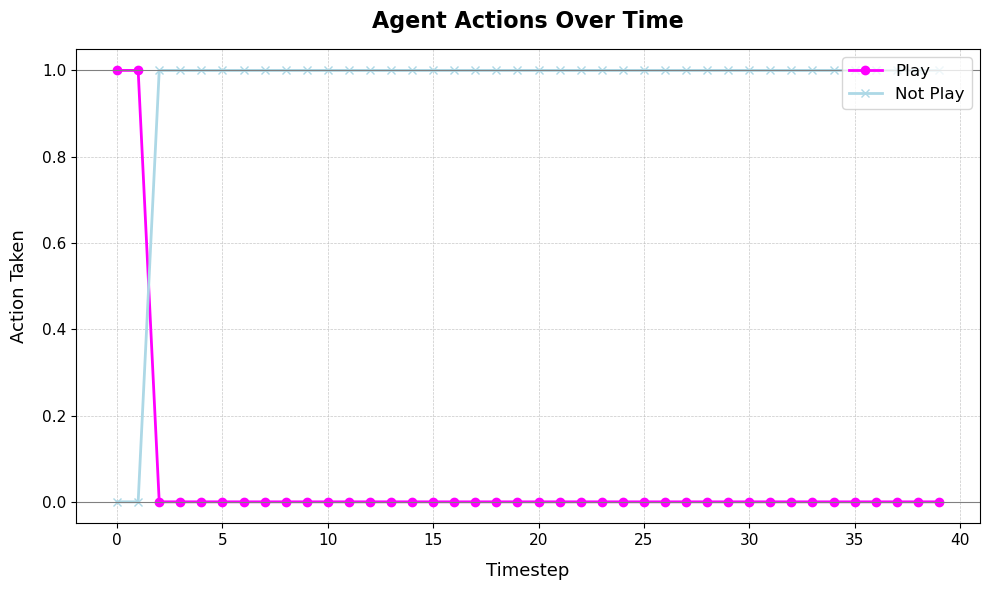

In [3]:
# Improved Plot: Agent Actions Over Time
plt.figure(figsize=(10, 6))
plt.plot(df["Step"], df["Play"], label="Play", marker='o', markersize=6, linewidth=2, color="magenta")
plt.plot(df["Step"], df["Not_Play"], label="Not Play", marker='x', markersize=6, linewidth=2, color="lightblue")


plt.title("Agent Actions Over Time", fontsize=16, weight='bold', pad=15)
plt.xlabel("Timestep", fontsize=13, labelpad=10)
plt.ylabel("Action Taken", fontsize=13, labelpad=10)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8)
plt.axhline(1, color='gray', linewidth=0.8)

plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()
